In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
sys.path.append("../data/biasbios")
sys.path.append("../data/embeddings/biasbios")
import classifier
import debias
import codecs
import json
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer
from transformers import BertTokenizer, BertModel, BertForMaskedLM
from numpy import dot
from numpy.linalg import norm

import scipy
from scipy import linalg
from scipy import sparse
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, SGDRegressor, Perceptron, LogisticRegression

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

import warnings
warnings.filterwarnings("ignore")

import pickle
from collections import defaultdict, Counter
from typing import List, Dict

import torch
from torch import utils

import copy
import pandas as pd
import time

In [2]:
def load_dataset(path):
    
    with open(path, "rb") as f:
        
        data = pickle.load(f)
    return data

def load_dictionary(path):
    
    with open(path, "r", encoding = "utf-8") as f:
        
        lines = f.readlines()
        
    k2v, v2k = {}, {}
    for line in lines:
        
        k,v = line.strip().split("\t")
        v = int(v)
        k2v[k] = v
        v2k[v] = k
    
    return k2v, v2k
    
def count_profs_and_gender(data: List[dict]):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["g"], entry["p"]
        counter[prof][gender] += 1
        
    return counter

In [3]:
!pwd
lang = "EN"
train_en = load_dataset("../data/biasbios/{}/train.pickle".format(lang))
dev_en = load_dataset("../data/biasbios/{}/dev.pickle".format(lang))
test_en = load_dataset("../data/biasbios/{}/test.pickle".format(lang))
g2i_en, i2g_en = load_dictionary("../data/biasbios/{}/gender2index.txt".format(lang))

path = "../data/bert_encode_biasbios/{}/".format(lang)
    
x_train_en = np.load(path + "train_avg_mbert.npy") 
x_dev_en = np.load(path + "dev_avg_mbert.npy") 
x_test_en = np.load(path + "test_avg_mbert.npy") 
y_train_gender_en = np.array([g2i_en[d["g"]] for d in train_en])
y_dev_gender_en = np.array([g2i_en[d["g"]] for d in dev_en])

lang = "FR"
train_fr = load_dataset("../data/biasbios/{}/train.pickle".format(lang))
dev_fr = load_dataset("../data/biasbios/{}/dev.pickle".format(lang))
test_fr = load_dataset("../data/biasbios/{}/test.pickle".format(lang))
g2i_fr, i2g_fr = load_dictionary("../data/biasbios/{}/gender2index.txt".format(lang))

path = "../data/bert_encode_biasbios/{}/".format(lang)
x_train_fr = np.load(path + "train_avg_mbert.npy") 
x_dev_fr = np.load(path + "dev_avg_mbert.npy") 
x_test_fr = np.load(path + "test_avg_mbert.npy") 
y_train_gender_fr = np.array([g2i_fr[d["g"]] for d in train_fr])
y_dev_gender_fr = np.array([g2i_fr[d["g"]] for d in dev_fr])


lang = "ES"
train_es = load_dataset("../data/biasbios/{}/train.pickle".format(lang))
dev_es = load_dataset("../data/biasbios/{}/dev.pickle".format(lang))
test_es = load_dataset("../data/biasbios/{}/test.pickle".format(lang))
g2i_es, i2g_es = load_dictionary("../data/biasbios/{}/gender2index.txt".format(lang))

path = "../data/bert_encode_biasbios/{}/".format(lang)
x_train_es = np.load(path + "train_avg_mbert.npy") 
x_dev_es = np.load(path + "dev_avg_mbert.npy") 
x_test_es = np.load(path + "test_avg_mbert.npy") 
y_train_gender_es = np.array([g2i_es[d["g"]] for d in train_es])
y_dev_gender_es = np.array([g2i_es[d["g"]] for d in dev_es])


/Users/hilagonen/Documents/mgender/dev/multi/inlp_release/src


In [4]:
print(len(train_en))
print(len(x_train_en))
print(len(train_fr))
print(len(x_train_fr))
print(len(train_es))
print(len(x_train_es))

255682
255682
42773
42773
46931
46931


## Load classifiers

In [5]:
directory = "final"


Ws_en = np.load("../data/inlp_matrices/EN/{}/Ws_mbert_300_EN_avg.npy".format(directory)) 
bs_en = np.load("../data/inlp_matrices/EN/{}/bs_mbert_300_EN_avg.npy".format(directory)) 
with open("../data/inlp_matrices/EN/{}/iters_mbert_300_EN_avg.json".format(directory)) as f:
    accs_en = json.load(f)


Ws_fr = np.load("../data/inlp_matrices/FR/{}/Ws_mbert_300_FR_avg.npy".format(directory)) 
bs_fr = np.load("../data/inlp_matrices/FR/{}/bs_mbert_300_FR_avg.npy".format(directory)) 
with open("../data/inlp_matrices/FR/{}/iters_mbert_300_FR_avg.json".format(directory)) as f:
    accs_fr = json.load(f)



Ws_es = np.load("../data/inlp_matrices/ES/{}/Ws_mbert_300_ES_avg.npy".format(directory)) 
bs_es = np.load("../data/inlp_matrices/ES/{}/bs_mbert_300_ES_avg.npy".format(directory)) 
with open("../data/inlp_matrices/ES/{}/iters_mbert_300_ES_avg.json".format(directory)) as f:
    accs_es = json.load(f)

    
W1_en = Ws_en[0].squeeze(axis=0)
W1_fr = Ws_fr[0].squeeze(axis=0)
W1_es = Ws_es[0].squeeze(axis=0)




## Evaluate with all 

In [6]:
def get_rowspace_projection(W: np.ndarray) -> np.ndarray:
    """
    :param W: the matrix over its nullspace to project
    :return: the projection matrix over the rowspace
    """

    if np.allclose(W, 0):
        w_basis = np.zeros_like(W.T)
    else:
        w_basis = scipy.linalg.orth(W.T) # orthogonal basis

    P_W = w_basis.dot(w_basis.T) # orthogonal projection on W's rowspace

    return P_W

def get_projection_to_intersection_of_nullspaces(rowspace_projection_matrices: List[np.ndarray], input_dim: int):
    """
    Given a list of rowspace projection matrices P_R(w_1), ..., P_R(w_n),
    this function calculates the projection to the intersection of all nullspasces of the matrices w_1, ..., w_n.
    uses the intersection-projection formula of Ben-Israel 2013 http://benisrael.net/BEN-ISRAEL-NOV-30-13.pdf:
    N(w1)∩ N(w2) ∩ ... ∩ N(wn) = N(P_R(w1) + P_R(w2) + ... + P_R(wn))
    :param rowspace_projection_matrices: List[np.array], a list of rowspace projections
    :param dim: input dim
    """

    I = np.eye(input_dim)
    Q = np.sum(rowspace_projection_matrices, axis = 0)
    P = I - get_rowspace_projection(Q)

    return P

In [7]:
from tqdm import tqdm

def eval(W, b, x, y):

    acc = 0
    for xi, yi in zip(x, y):
        if np.dot(W,xi) + b > 0 and yi == 1:
            acc += 1
        elif np.dot(W,xi) + b < 0 and yi == 0:
            acc += 1

    return acc/len(x)
    

In [8]:
def eval_all_clf(Ws, bs, x_dev, y_dev_gender):

    accs_en_manual = []
    input_dim = 768
    P = np.eye(input_dim)
    rowspace_projections = []
    for W, b in tqdm(zip(Ws, bs)):

        P_rowspace_wi = get_rowspace_projection(W) # projection to W's rowspace
        rowspace_projections.append(P_rowspace_wi)

        W = W.squeeze(axis=0)
        acc = eval(W, b, x_dev.dot(P), y_dev_gender)
        accs_en_manual.append(acc)

        P = get_projection_to_intersection_of_nullspaces(rowspace_projections, input_dim)

    return accs_en_manual

In [9]:

# eval across all langs
# This cell takes time! 

en_on_en = eval_all_clf(Ws_en, bs_en, x_dev_en, y_dev_gender_en)
en_on_fr = eval_all_clf(Ws_en, bs_en, x_dev_fr, y_dev_gender_fr)
en_on_es = eval_all_clf(Ws_en, bs_en, x_dev_es, y_dev_gender_es)

fr_on_en = eval_all_clf(Ws_fr, bs_fr, x_dev_en, y_dev_gender_en)
fr_on_fr = eval_all_clf(Ws_fr, bs_fr, x_dev_fr, y_dev_gender_fr)
fr_on_es = eval_all_clf(Ws_fr, bs_fr, x_dev_es, y_dev_gender_es)

es_on_en = eval_all_clf(Ws_es, bs_es, x_dev_en, y_dev_gender_en)
es_on_fr = eval_all_clf(Ws_es, bs_es, x_dev_fr, y_dev_gender_fr)
es_on_es = eval_all_clf(Ws_es, bs_es, x_dev_es, y_dev_gender_es)


300it [07:10,  1.43s/it]
300it [03:19,  1.50it/s]
300it [03:40,  1.36it/s]
300it [06:55,  1.39s/it]
300it [03:23,  1.48it/s]
300it [03:48,  1.31it/s]
300it [08:40,  1.73s/it]
300it [03:00,  1.66it/s]
300it [03:02,  1.65it/s]


In [10]:
en_on_en_fixed = [x if x > 0.5 else 1-x for x in en_on_en]
en_on_fr_fixed = [x if x > 0.5 else 1-x for x in en_on_fr]
en_on_es_fixed = [x if x > 0.5 else 1-x for x in en_on_es]

fr_on_en_fixed = [x if x > 0.5 else 1-x for x in fr_on_en]
fr_on_fr_fixed = [x if x > 0.5 else 1-x for x in fr_on_fr]
fr_on_es_fixed = [x if x > 0.5 else 1-x for x in fr_on_es]

es_on_en_fixed = [x if x > 0.5 else 1-x for x in es_on_en]
es_on_fr_fixed = [x if x > 0.5 else 1-x for x in es_on_fr]
es_on_es_fixed = [x if x > 0.5 else 1-x for x in es_on_es]




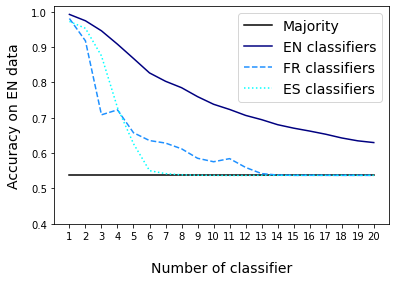

In [11]:
plt.plot(range(1,21), 20*[0.5371], color="black", label="Majority")
plt.plot(range(1,21), en_on_en_fixed[:20], "-", color="navy", label="EN classifiers")
plt.plot(range(1,21),fr_on_en_fixed[:20], "--", color="dodgerblue", label="FR classifiers")
plt.plot(range(1,21),es_on_en_fixed[:20], ":", color="cyan", label="ES classifiers")
plt.xlabel("Number of classifier", labelpad=20, fontsize=14)
plt.ylabel("Accuracy on EN data", labelpad=10, fontsize=14)
plt.ylim(ymin = 0.4)
plt.xticks(np.arange(1, 21, step=1))
plt.legend(fontsize=14)
plt.show()


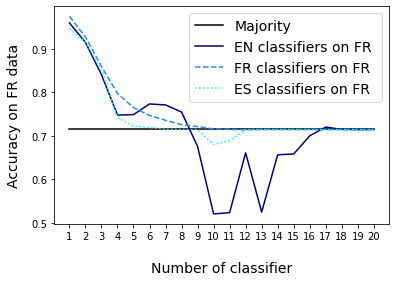

In [12]:
plt.plot(range(1,21), 20*[0.7149], color="black", label="Majority")
plt.plot(range(1,21), en_on_fr_fixed[:20], "-", color="navy", label="EN classifiers on FR ")
plt.plot(range(1,21),fr_on_fr_fixed[:20], "--", color="dodgerblue", label="FR classifiers on FR ")
plt.plot(range(1,21),es_on_fr_fixed[:20], ":", color="cyan", label="ES classifiers on FR ")
plt.xlabel("Number of classifier", labelpad=20, fontsize=14)
plt.ylabel("Accuracy on FR data", labelpad=10, fontsize=14)
plt.xticks(np.arange(1, 21, step=1))
plt.legend(fontsize=14)
plt.show()


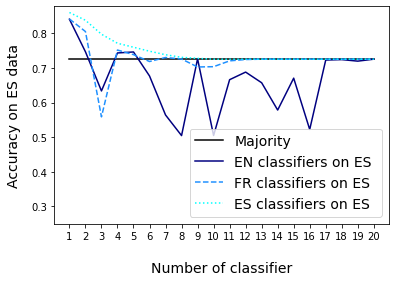

In [13]:
plt.plot(range(1,21), 20*[0.7258], color="black", label="Majority")
plt.plot(range(1,21), en_on_es_fixed[:20], "-", color="navy", label="EN classifiers on ES ")
plt.plot(range(1,21), fr_on_es_fixed[:20], "--", color="dodgerblue", label="FR classifiers on ES ")
plt.plot(range(1,21), es_on_es_fixed[:20], ":", color="cyan", label="ES classifiers on ES ")
plt.xlabel("Number of classifier", labelpad=20, fontsize=14)
plt.ylabel("Accuracy on ES data", labelpad=10, fontsize=14)
plt.ylim(ymin = 0.25)
plt.xticks(np.arange(1, 21, step=1))
plt.legend(fontsize=14, loc="lower right")
plt.show()
